<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
# Широкоформатный Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Импортируем базы данных, которые пригодятся в нашем исследование

# импорты из стандартной библиотеки
import warnings
import re
import os

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy import stats as st

# импорты модулей текущего проекта
!pip3 install prettytable
from prettytable import PrettyTable

!pip install pmdarima
from pmdarima import auto_arima

!pip install prophet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as ts
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from catboost import Pool, CatBoostRegressor, cv
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from sklearn.dummy import DummyRegressor



# настройка
# игнорируем ошибки matplotlib
warnings.filterwarnings("ignore")

# зафиксируем RandomState
STATE = np.random.RandomState(12345)

In [3]:
# Прочитаем файл и сохраним в датафрейм

pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=[0], index_col=[0]).sort_index(ascending=True)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=[0], index_col=[0]).sort_index(ascending=True)
else:
    print('Something is wrong')

In [4]:
data.shape

(26496, 1)

In [5]:
# Создадим функцию для облегчения дальнейшего знакомства с данными
def information(data):

# Посмотрим основную информацию датафрейма
    display(data.info(), data.describe(include='all').T.round(2), data.head())

# Посмотрим кол-во дубликатов
    print('Кол-во дубликатов', data.duplicated().sum())
    print('')

# Проверим кол-во пропусков в столбцах датафрейма
# Сделаем функцию, которая возвращает таблицу с количеством и долей пропусков в датафрейме
    def isna_info(df):
        isna_count = df.isna().sum() # кол-во пропусков
        # дублируем столбец с пропущенными значениями и высчитываем процент, объединяем таблицы
        isna_table = (pd.concat([isna_count / df.shape[0], isna_count], axis=1,  keys=['percent', 'count'])
        # сортируем по убыванию, удаляем из таблцы непропущенные значения              
           .sort_values('percent', ascending=False)).loc[lambda x: x["count"] > 0]
        return isna_table
    print('Кол-во параметров с пропусками в столбцах:', len(isna_info(data)), '\n'), display(isna_info(data))
    
    # Построим общую гистограмму для всех столбцов таблицы
    data.hist(figsize=(15, 8))
    plt.xlabel('Число заказов такси')
    plt.ylabel('Суммарное кол-во для X заказов такси')
    plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.07,9.21,0.0,8.0,13.0,19.0,119.0


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Кол-во дубликатов 26415

Кол-во параметров с пропусками в столбцах: 0 



,percent,count


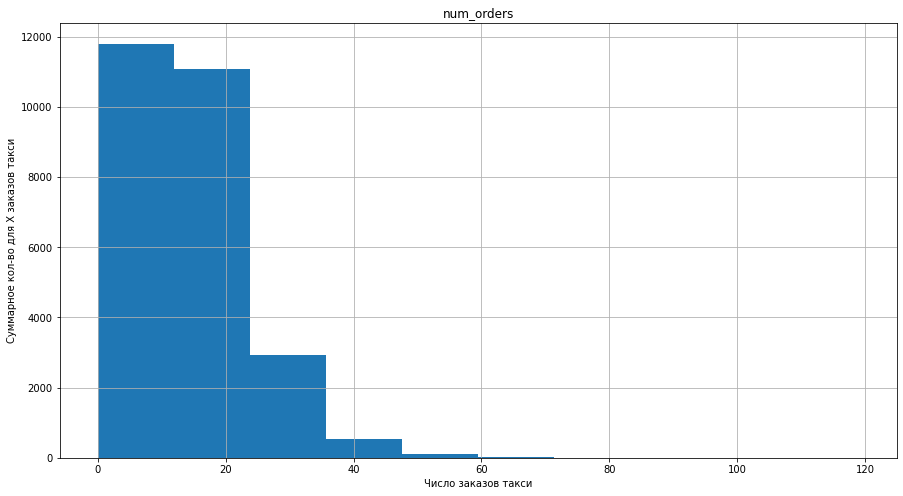

In [6]:
# Посмотрим информация по датасету
information(data)

В нашем датафрейме 26495 строк и 2 столбца со временем и числом заказов такси. Наименования столбцов соблюдены по правилам написания кода PEP8. Явные дубликаты и пропуски данных отсутсвуют. Столбец `datetime` показывает нам временные интервалы по 10 минут. Изменим тип данных с object на datetime64, затем установим индекс таблицы равным столбцу `datetime`. Относительно `num_orders` - максимальное число заказов в пике равно 119 заказам, при этом основное распределение варьирует до значения не более 21 заказа в 10 минутный интервал. Среднее значение стримится к медиане и равно 13-14 заказов.

In [9]:
# Чтобы проверить, в хронологическом ли порядке расположены даты и время,
# посмотрим атрибут индекса таблицы is_monotonic (англ. «монотонный»). 
# Если порядок соблюдён, атрибут вернёт True, если нет — False.
print(f'Хронологический ли порядок: {data.index.is_monotonic}')
print('')
print(data.info())

Хронологический ли порядок: True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Данные у нас за полгода с **2018-03-01 00:00:00** по **2018-08-31 23:50:00**

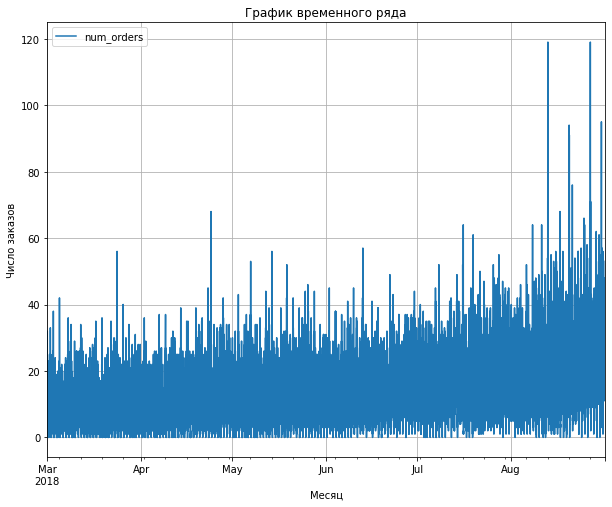

In [10]:
# Посмотрим график временного ряда.
data.plot(figsize=(10,8), grid = True, title='График временного ряда')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.show()

Визуально видим, что кол-во заказов к августу увеличивается. Для более детального анализа нужно посмореть подробнее.

Выполним **ресемплирование** (или *ресемплинг* (англ. resample, «повторная выборка») — это изменение интервала со значениями ряда) **по одному часу**.

In [11]:
# Чтобы поменять интервал и сгруппировать значения, вызовем функцию resample(), а затем sum(), для группировки по суммарному значению за час.
data = data.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


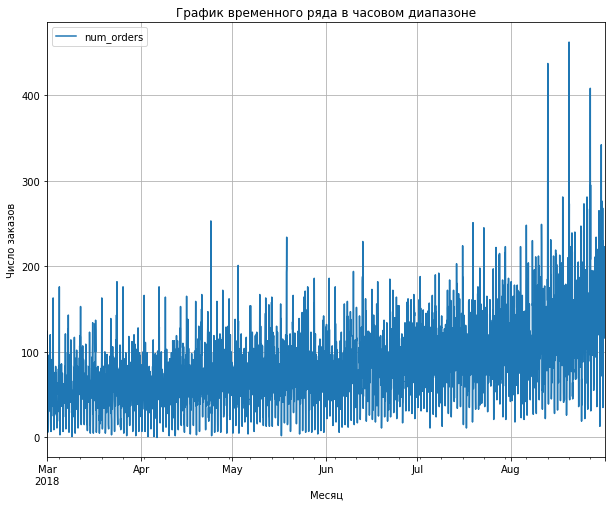

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [12]:
display(data.head())
# посмотрим график
data.plot(figsize=(10,8), grid = True, title='График временного ряда в часовом диапазоне')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.show()

# и статистические данные
data.describe()

График стал плавнее. Визуально выглядит, что кол-во заказов к лету с каждым месяцем становится все больше, далее посмотрим на это. Присутствует увелечение средних значений.

Временной интревал теперь 1 час, а не 10 минут. За час в среднем идет 84 заказа, что уже дальше от медианого значени в 78. Максимальное кол-во заказов час 462, а вот минимальное - 0, есть часы, когда такси неактуально.

## Анализ

Для облегчения дальннейшего анализа проверим, стационарный (это ряд, у которого среднее и стандартное отклонение не меняются, а так же отсутсвует сезонность и тренд) ли у нас временной ряд или нет. Если ряд нестационарный, то его прогнозировать сложнее: свойства меняются слишком быстро.

In [13]:
# сделаем копию датафрейма
data_taxi = data.copy()

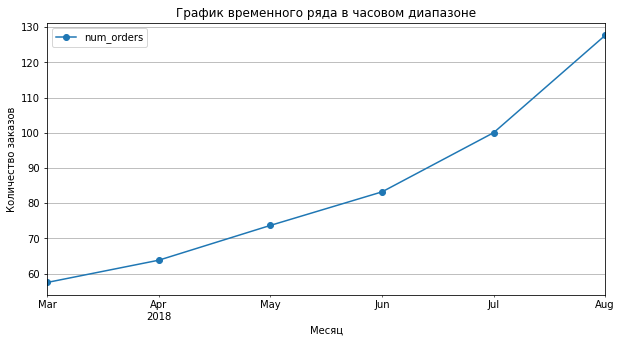

In [14]:
# посмотрим помесячное распределение

data_taxi.resample('1M').mean().plot(figsize=(10,5), grid = True, style='o-', title='График временного ряда в часовом диапазоне')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Все верно, присутсвует месячный тренд по кол-ву заказов.

Посмотрим на распределение среднего и отклонения построенных со скользящим окном.

In [15]:
# возьмем размер окна (англ. window size) — интервал, в котором выполняют усреднение, равным суткам (24 часа)
data_taxi['mean_orders'] = data_taxi['num_orders'].rolling(24, closed='left').mean() # среднее значение
data_taxi['std_orders'] = data_taxi['num_orders'].rolling(24, closed='left').std() # отклонение

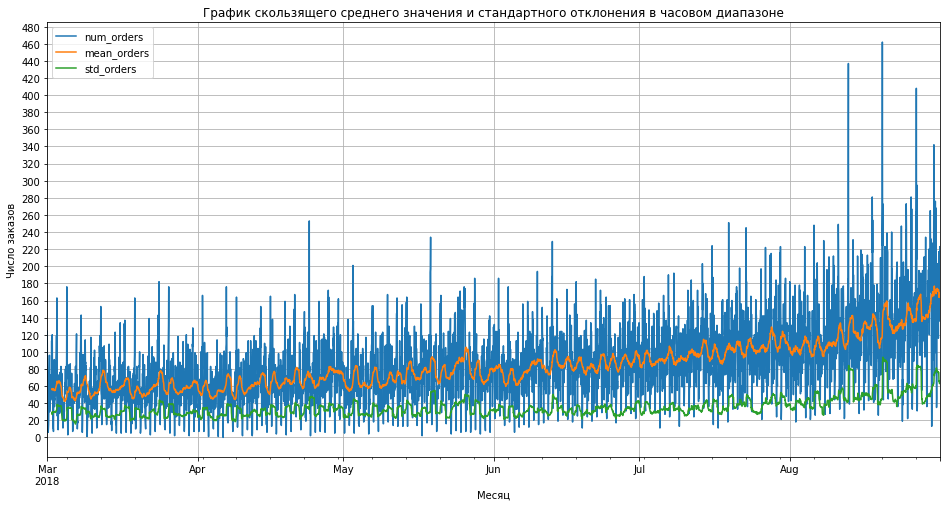

In [16]:
# посмотрим график
data_taxi.plot(figsize=(16,8), grid = True, title='График скользящего среднего значения и стандартного отклонения в часовом диапазоне')
plt.xlabel('Месяц')
plt.yticks(ticks=np.arange(0,500,20))
plt.ylabel('Число заказов')
plt.show()

Видим увеличение среднего начиная с мая месяца и изменение среднего отклонения в августе. Из-за изменения в большую сторону линии сглаживания скользящим средним можем предположить, что временной ряд у нас нестационарен. Посмотрим подробнее далее.

Разложим на **Тренд** (англ. trend) — плавное изменение среднего значения ряда без повторяющихся закономерностей, и **Сезонность** (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду..

В модуле `tsa.seasonal` (от англ. time series analysis, «анализ временных рядов») библиотеки `statsmodels` (англ. «статистические модели») есть функция `seasonal_decompose()` (англ. «разбить на части»). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.

Функция `seasonal_decompose()` принимает временной ряд, а возвращает объект структуры **DecomposeResult** (англ. «результат разделения»). В нём есть нужные атрибуты:
- `decomposed.trend` — тренд;
- `decomposed.seasonal` — сезонная составляющая;
- `decomposed.resid` — остаток декомпозиции.

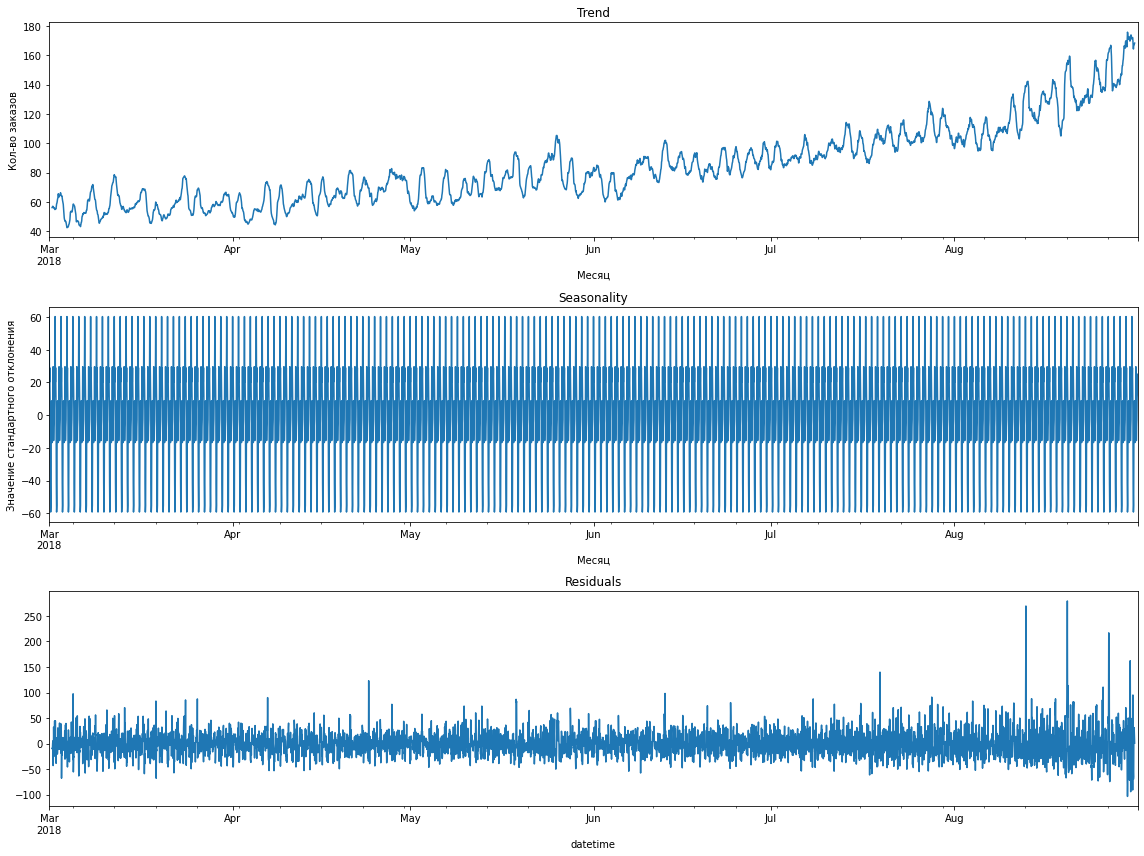

In [17]:
# декомпозируем данные
decomposed = seasonal_decompose(data_taxi['num_orders'])

# Смотрим граффик
plt.figure(figsize=(16, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Кол-во заказов')
plt.xlabel('Месяц')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Значение стандартного отклонения')
plt.xlabel('Месяц')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Заметна как ежедневная сезонность с постоянной переодичностью, так и возрастающий тренд. Но изменим наш масштаб, посмотрим в рамках недели на сезонность.

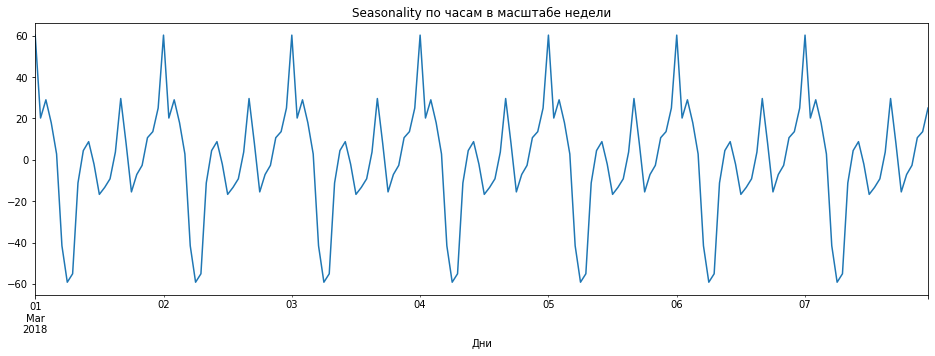

In [18]:
plt.figure(figsize=(16, 5))
decomposed.seasonal[:(24*7)].plot()
plt.title('Seasonality по часам в масштабе недели')
plt.xlabel('Дни')
plt.show()

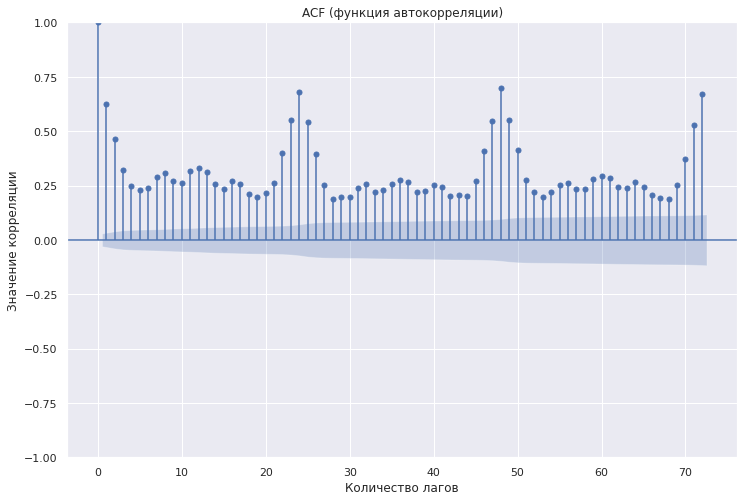

In [19]:
# посмотрим на автокорелляцию со смещением (lags) в 72 часа
sns.set(rc={'figure.figsize':(12,8)})
fig = tsaplots.plot_acf(data_taxi['num_orders'], lags=72)
plt.xlabel('Количество лагов')
plt.ylabel('Значение корреляции')
plt.title('ACF (функция автокорреляции)')
plt.show()

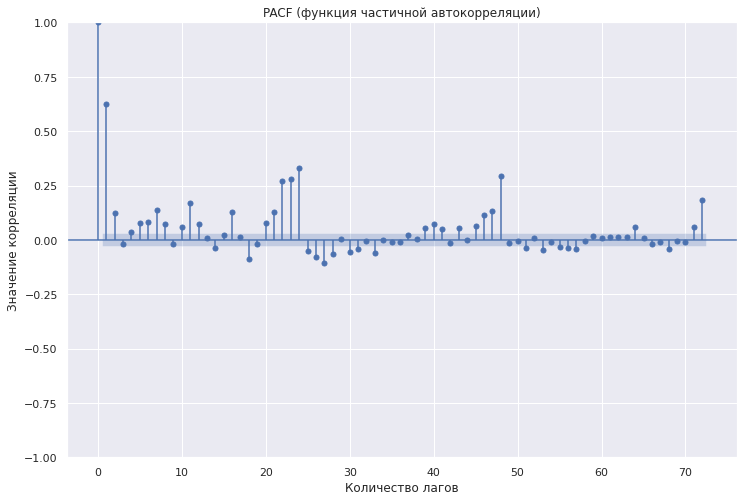

In [20]:
# Посмотрим на частичную автокорреляцию
sns.set(rc={'figure.figsize':(12,8)})
fig = tsaplots.plot_pacf(data_taxi['num_orders'], lags=72)
plt.title('PACF (функция частичной автокорреляции)')
plt.xlabel('Количество лагов')
plt.ylabel('Значение корреляции')
plt.show()

Сезонность и тренд подтверждается (так как ряд выходит из доверительного интервала (синий "конус") и тогда автокорреляция является значимой). Ряд не стационарный. Сезонность в 24 часа. С помщью автокорреляции мы видим зависимость сигнала (значения) с самим собой в разные моменты времени. В нашем случае видим повторение значений и самую высокую автокорреляцию через 24 лага. Подтверждает график "Сезонности по часам в масштабе недели", где мы видим, одинаковый "цикл" кривой, которая повторяется, каждый день. 

Воспользуемся тестом Дики-Фуллера

Сформулируем гипотезу о стационарности ряда.

**Гипотеза:** Является ли временной ряд стационнарным? Если временной ряд является стационарным, то его можно легко анализировать и прогнозировать.

- Проверяем гипотезу. 
- Нулевая гипотеза H0 - временной ряд не является стационнарном.
- Альтернативная гипотеза H1 - гипотеза о стационарности ряда.

In [21]:
def adf(series, alpha=0.01):
    p_value = ts.adfuller(series)[1]
    print(f'p-value = {p_value}')
    print(f'adf: {ts.adfuller(series)[0]}')
    print(f'critical values: {ts.adfuller(series)[4]}')
    if p_value > alpha:
        print(f'Не можем отвергнуть нулевую гипотезу о нестационарности ряда')
    else:
        print(f'Ряд стационарный')
        
adf(data_taxi['num_orders'])        

p-value = 0.028940051402612906
adf: -3.0689242890279558
critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Не можем отвергнуть нулевую гипотезу о нестационарности ряда


После анализа графиков и проведение теста Дики-Фуллера подтвердили нестационарность ряда. Будем иметь ввиду что, потенциально при работе с нестационарным рядом ошибка прогноза может быть выше.

## Обучение

В качестве моделей буем рассматривать:

**Линейная регрессия (Linear Regression)** - применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков. Модель [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) лежит в модуле sklearn.linear_model (от англ. «линейная модель») библиотеки sklearn. Импортируем его: `from sklearn.linear_model import LinearRegression`

**Prophet** - библиотека для прогнозирования временных рядов Facebook. [Prophet](https://facebook.github.io/prophet/) - это процедура прогнозирования данных временных рядов на основе аддитивной модели, где нелинейные тренды соответствуют годовой, еженедельной и ежедневной сезонности, а также эффектам праздников. Лучше всего это работает с временными рядами, которые имеют сильные сезонные эффекты, и с несколькими сезонами исторических данных. Prophet устойчив к отсутствующим данным и изменениям в тренде и обычно хорошо справляется с выбросами. Импортируем её из библиотеки: `from prophet import Prophet`

**SARIMA** - расшифровывается как Seasonal ARIMA (сезонная авторегрессивная интегрированная скользящая средняя). [SARIMA](https://www.statsmodels.org/dev/statespace.html#seasonal-autoregressive-integrated-moving-average-with-exogenous-regressors-sarimax) — это вариант ARIMA (который, в свою очередь, представляет собой комбинацию AR и MA вместе с буквой «I» в середине, что означает «интегрированный»). Имеет два набора параметров: несезонные (p, d, q) и сезонные (P, D, Q, m). Импортируем его: `import statsmodels.api as sm`

**CatBoost** - библиотека градиентного бустинга, созданная Яндексом. [CatBoost](https://catboost.ai/) - это алгоритм для повышения градиента на деревьях решений. Использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (split) на каждом уровне дерева. Импортируем: `from catboost import CatBoostRegressor`


Перед обучением необходимо создадать признаки для горизонта прогнозирования:
- *Календарные признаки (англ. calendar features)*. Во многих данных тренды и сезонность привязаны к конкретной дате. Тип datetime64 в Pandas уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы.
- *«Отстающие значения» (англ. lag features)*. Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. Получим отстающие значения функцией shift().
- *Скользящее среднее*. Скользящее среднее как признак задаёт общий тренд временного ряда. Если скользящее среднее в моменте t учитывает текущее значение ряда x(t), то это некорректно: целевой признак «убежал» в признаки. Вычисление скользящего среднего не должно включать в себя текущее значение ряда.

In [23]:
# сделаем копию датафрейма для модели Prophet
data_pr = data.reset_index()[['datetime', 'num_orders']].copy()
display(data_pr.head())

# определим размер скользящего окна
def best_rolling(data):
    best_rmse = 1000
    best_rolling_size = 0
    for rolling_size in range(1, 50, 1):
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
        data.dropna(inplace=True)
        rmse = mean_squared_error(data['num_orders'], data['rolling_mean']) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_rolling_size = rolling_size
    print(
        f'RMSE: {best_rmse:.2f}\n'
        f'Размер скользящего окна: {best_rolling_size}\n'
    )

best_rolling(data)

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


RMSE: 37.50
Размер скользящего окна: 26



In [24]:
# Напишем функцию для создания признаков.

def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
#     прибавляем к таблице четыре новых календарных признака
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
#     Вычислим отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:, 0].shift(lag)

    # Вычислим скользящее среднее
    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(rolling_mean_size).mean()
    
    return data

# применим
data_fit = make_features(data, 24, 26)
data_fit.sample(6)

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-14 23:00:00,81,88.769231,14,0,23,106.0,81.0,72.0,98.0,52.0,...,66.0,42.0,13.0,30.0,58.0,129.0,164.0,106.0,158.0,130.0
2018-08-03 04:00:00,172,102.038462,3,4,4,78.0,125.0,130.0,178.0,170.0,...,98.0,84.0,72.0,122.0,102.0,84.0,31.0,18.0,66.0,117.0
2018-06-09 13:00:00,86,86.230769,9,5,13,91.0,74.0,65.0,89.0,103.0,...,106.0,114.0,85.0,67.0,76.0,82.0,121.0,80.0,85.0,78.0
2018-06-27 00:00:00,134,82.384615,27,2,0,116.0,100.0,79.0,73.0,82.0,...,83.0,62.0,41.0,39.0,17.0,89.0,93.0,95.0,99.0,104.0
2018-07-23 02:00:00,182,103.653846,23,0,2,135.0,245.0,155.0,105.0,104.0,...,80.0,54.0,74.0,55.0,40.0,61.0,43.0,149.0,128.0,97.0
2018-07-30 07:00:00,32,112.461538,30,0,7,21.0,119.0,140.0,155.0,223.0,...,178.0,119.0,135.0,116.0,108.0,60.0,68.0,98.0,62.0,24.0


Разделим данные на обучающую и тестовую выборки. Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.
Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. Значения этих признаков NaN. Их нужно удалить.

In [25]:
#  Обучающая выборка
# на валидационную и тестовую выборку отправляем 20% исходных данных

train, valid = train_test_split(data_fit, shuffle=False, test_size=0.2)
train = train.dropna()

In [26]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis = 1)
target_valid = valid['num_orders']


# Смотрим размер выборки 
print(features_train.shape)
print(target_train.shape)

(2526, 28)
(2526,)


In [27]:
#  Валидационная и тестовая выборки
# test_size = 0.5, выборки делим пополам

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, shuffle=False)

# Смотрим размер выборки 
print('Размер валидационной выборки:\n', features_valid.shape, '\n', target_valid.shape)
print('')
print('Размер тестовой  выборки:\n', features_test.shape, '\n', target_test.shape)

Размер валидационной выборки:
 (319, 28) 
 (319,)

Размер тестовой  выборки:
 (320, 28) 
 (320,)


Мы с вами создали признаки для горизонта прогназирования и подобрали их оптимальыне значения, а именно календарные признаки, отстающее значение равное 24 и скользящее значение равное 26. 

Разбили данные на обучающую, валидационную и тестовую выборки. На обучение ушло 2526 записей, на валидационную и тестовую по 320-319 записи для каждой выборки соответсвенно.

In [28]:
# Создадим таблицу результатов, куда будем заносить интересующие нас результаты
table = PrettyTable()
table.field_names = ['model','RMSE']
print(table)

+-------+------+
| model | RMSE |
+-------+------+
+-------+------+


Метрика качетсва - **RMSE (Корень из среднеквадратичной ошибки)** представляет собой показатель, указывающий нам среднее расстояние между прогнозируемыми значениями из модели и фактическими значениями в наборе данных. Чем ниже RMSE, тем лучше данная модель может «соответствовать» набору данных.

In [29]:
# сделаем функцию для подсчета RMSE
def rmse(x_valid, y_predicted):
    return mean_squared_error(x_valid, y_predicted, squared=False)

In [30]:
# функция для визуализации
def graf(pred, title):
    plt.figure(figsize=(25, 10))

    sns.lineplot(x=target_valid.index, y=target_valid, label= 'real')
    sns.lineplot(x=target_valid.index, y=pred, label='predicted')
    plt.xlabel('Дата', fontsize=18)
    plt.ylabel('Кол-во заказов', fontsize=18)
    plt.legend()
    plt.title(f'Сравнение предсказанного и истинного кол-во заказов в {title}', fontsize=24)

    plt.show()

**Линейная регрессия (LinearRegression)**

In [31]:
lr = LinearRegression() # инициализируем модель
lr.fit(features_train, target_train) #обучим модель на тренировочной выборке
lr_predicted = lr.predict(features_valid) # получим предсказания модели на валидационной выборке
#  Посчитаем значение метрики на валидационной выборке
rmse_lr = rmse(target_valid, lr_predicted)
print(f'Лучшее значение RMSE для Линейной регрессии: {rmse_lr}')

Лучшее значение RMSE для Линейной регрессии: 37.7712236820596


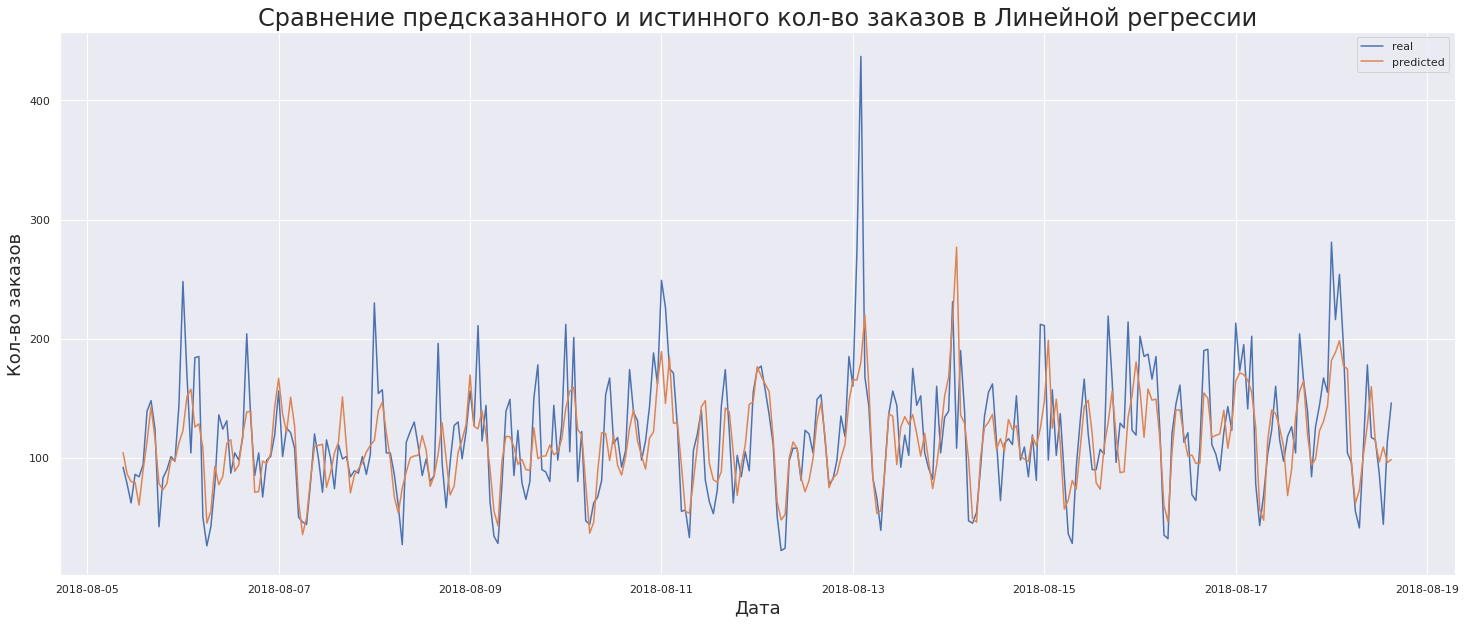

In [32]:
# визуализация
graf(lr_predicted, 'Линейной регрессии')

In [33]:
# Вносим данные в таблицу
table.add_row(['Linear Regression', rmse_lr])
print(table)

+-------------------+------------------+
|       model       |       RMSE       |
+-------------------+------------------+
| Linear Regression | 37.7712236820596 |
+-------------------+------------------+


**Prophet**

Библиотека Prophet хорошо работает с временными рядами, имеющими сизональные эффекты, она устойчива к отсутсвующим данным и к изменению тренда, хорошо справляется с выбросами. Модель не очень сильная, но простая.

Имеет интерфейс похожий на `sklearn`, сначала мы создаем модель, затем вызываем у нее метод `fit` и затем получаем прогноз. На вход методу `fit` библиотека принимает dataframe с двумя колонками:


`ds` — время, поле должно быть типа date или datetime,
`y` — числовой показатель, который мы хотим предсказывать.

In [34]:
# переименуем столбцы
data_pr.columns = ['ds', 'y']

In [35]:
#  выборки

VALID_SIZE = int(0.2 * data_pr.shape[0])
train_data = data_pr.iloc[:-VALID_SIZE]
valid_data = data_pr.iloc[-VALID_SIZE:]

print(train_data.shape)

(3533, 2)


In [36]:
TEST_SIZE = int(0.5 * valid_data.shape[0])
valid_data = valid_data.iloc[:-TEST_SIZE]
test_data = valid_data.iloc[-TEST_SIZE:]

print(valid_data.shape)
print(test_data.shape)

(442, 2)
(441, 2)


In [37]:
# обучим модель
m = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')

In [38]:
m.fit(train_data)

17:15:50 - cmdstanpy - INFO - Chain [1] start processing
17:15:51 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# предскажем
future = m.make_future_dataframe(periods=VALID_SIZE, freq='H')
forecast = m.predict(future)

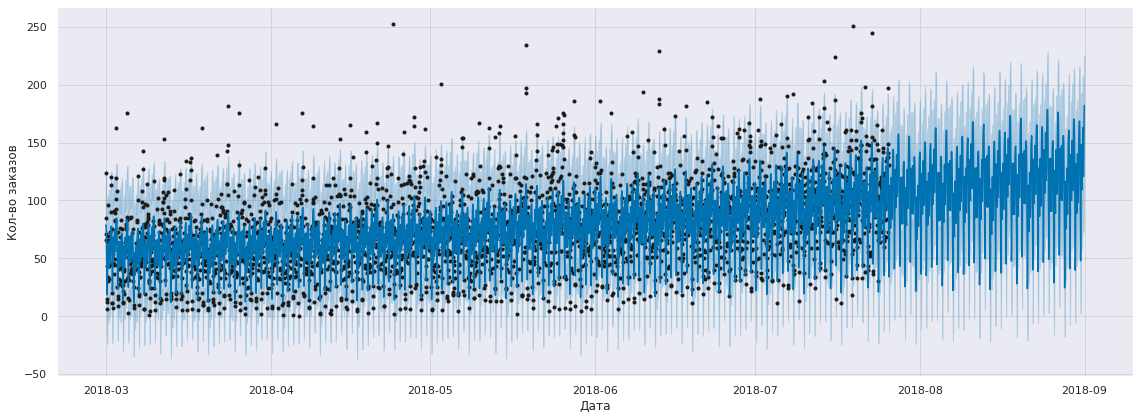

In [40]:
m.plot(forecast, figsize=(16,6))
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

In [41]:
prohed_pred = pd.DataFrame({"Date": forecast['ds'],
                           "Pred": forecast['yhat']})
prohed_pred = prohed_pred.set_index("Date")
prohed_pred[:-VALID_SIZE].tail()

,Pred
Date,
2018-07-26 00:00:00,145.367635
2018-07-26 01:00:00,145.540199
2018-07-26 02:00:00,141.112908
2018-07-26 03:00:00,123.501448
2018-07-26 04:00:00,90.348405


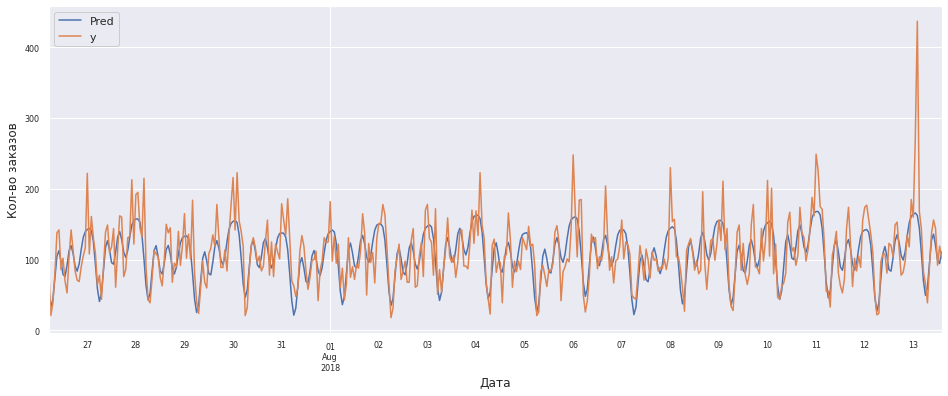

In [42]:
plt.figure(figsize=(16,6))

prohed_pred[-VALID_SIZE :-TEST_SIZE]["Pred"].plot(fontsize=8)
valid_data = valid_data.set_index(['ds'])
valid_data['y'].plot(fontsize=8)
plt.legend(loc = 'best', framealpha =1)
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

In [43]:
rmse_pr = rmse(valid_data['y'], prohed_pred[-VALID_SIZE :-TEST_SIZE]["Pred"])
print(f'Лучшее значение RMSE для Prophet: {rmse_pr}')

Лучшее значение RMSE для Prophet: 31.875369358837524


In [44]:
# Вносим данные в таблицу
table.add_row(['Prophet', rmse_pr])
print(table)

+-------------------+--------------------+
|       model       |        RMSE        |
+-------------------+--------------------+
| Linear Regression |  37.7712236820596  |
|      Prophet      | 31.875369358837524 |
+-------------------+--------------------+


**[SARIMA(p,d,q)(P,D,Q,s)](https://russianblogs.com/article/60511336750/)** 

Модель сезонного авторегрессионного скользящего среднего с семью структурными параметрами

***AR(p)*** Модель авторегрессии, то есть использовать себя, чтобы вернуться к себе. Основное предположение состоит в том, что текущее значение последовательности зависит от исторической ценности последовательности. p указывает, сколько исторических значений используется для возврата прогнозируемого значения.

Чтобы определить начальный p, нужно посмотреть на *PACF*. Изобразите и найдите самое большое значимое запаздывание по времени, а остальные запаздывания не значимы после p.

***MA(q)*** Модель скользящего среднего предназначена для моделирования ошибки временного ряда и предположения, что текущая ошибка зависит от ошибки с запаздыванием. допустимый *ACF* Найдите начальное значение на карте.

Объедините два вышеуказанных метода: *AR(p)+MA(q)=ARMA(p,q)*, Модель авторегрессионного скользящего среднего

Остальные параметры:

***I(d)*** Указывает, что порядок интегрирования равен D. Интегрирование происходит потому, что мы сначала дифференцируем временной ряд d раз, чтобы сделать ряд стабильным. Например, парабола дифференцируется дважды, чтобы получить устойчивое (стационарное) ускорение, правильное ускорение оценивается, а интегрирование выполняется дважды, чтобы восстановить исходный временной ряд.

Теперь у нас есть модель ARIMA, которая может моделировать нестационарные ряды без сезонных изменений.

***S(s)*** Используется для моделирования сезонности последовательности, s представляет продолжительность сезона.

С учетом сезонности требуются три дополнительных параметра **(P, D, Q)**.

***P*** представляет собой порядок сезонной авторегрессии, выведенный из PACF. В отличие от малого p, необходимо учитывать временной лаг, кратный длине сезона. Например, если продолжительность сезона 24, то на диаграмме pacf следует проверить интенсивность лагов 24,48,72. Если pacf последовательности с лагом 48 является значимым, то P равно 2.

***Q*** и ***P*** берутся аналогично, но выбираются через диаграмму ACF.

***D*** представляет порядок сезонной разницы, которая обычно составляет 0 или 1. Сезонная разница составляет 1.

In [45]:
# # будем использовать метод Auto ARIMA для автоматической настройки / поиска оптимальных значений p, q и P, Q.
# sarimax_model = auto_arima(target_train,
#                           start_p = 0,
#                           start_q = 0,
#                           max_p = 3,
#                           max_q = 3,
#                           m = 12,
#                           test = 'adf',
#                           seasonal = True,
#                           d = 1,
#                           D = 1,
#                           trace = True,
#                           error_action = 'ignore',
#                           suppress_warnings = True,
#                           stepwise = True)
# sarimax_model.summary()

In [46]:
#  # впишем лучшие значения параметров
# my_order = ()
# my_seasonal_order= ()


# # обучим
# sarimax_model = sm.tsa.statespace.SARIMAX(target_train, order=my_order, 
#                                         seasonal_order=my_seasonal_order).fit()

# # посмотрим предсказание
# sarim_predicted = sarimax_model.predict(start = 1, end = target_valid.shape[0])

# # качество метририки
# rmse_sarim = rmse(target_valid, sarim_predicted)
# print(f'Лучшее значение RMSE для Линейной регрессии: {rmse_sarim}')


<div class style="border-radius: 7px; box-shadow: 3px 3px 1px; border: 2px solid ">
    
Отказался от расчета модели SARIMAX из-за долго обучения и автоподбора параметров (Jupyter выдает ошибку о падение сервера и окончание сессии.)

Выше код "закомментил" 

**CatBoostRegressor**

CatBoost позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать. Даже говорится, что из "коробки" реультаты кодирования лучше.

In [48]:
cat_features = ['day', 'dayofweek', 'hour']

# обучаем

best_model = None
best_rmse = 48 # условие проекта

for depth in range (1,6):
    cat = CatBoostRegressor( # подбираем гиперпараметры
    #n_estimators = 250, # кол-во эпох
        depth = depth, # глубина 
        iterations = 10000, # кол-во итераций
        learning_rate=0.1, # шаг обучения
#         metric_period=200, # отображение результатов под графиком через какой шаг
        od_type='Iter', # детектор переобучения
        od_wait=50, # через сколько итераций сработает детектор
        verbose=False
    ) 
    cat.fit(
    features_train, target_train, # передаем обучающую выборку
    cat_features=cat_features, # передаем категориальные признаки
    #eval_set=(features_valid, target_valid), # валидационная выборка
    plot=False # график
    )
    
    # получим предсказания модели на валидационной выборке
    cat_predicted = cat.predict(features_valid)

    #  Посчитаем значение метрики на валидационной выборке
    rmse_cat = rmse(target_valid, cat_predicted)
    print(f" best_depth = {depth}, rsme = {rmse_cat}")
    if rmse_cat <= best_rmse:
            best_depth = depth # сохраним наилучшее показание глубины дерева
            best_model = cat # сохраним наилучшую модель
            best_rmse = rmse_cat # сохраним наилучшее значение rsme
            
best_rmse_cat = best_rmse  
print(f'Лучшее значение RMSE для CatBoostRegressor: {best_rmse_cat} при глубине {best_depth}')        

 best_depth = 1, rsme = 39.69327979315016
 best_depth = 2, rsme = 37.17276921696631
 best_depth = 3, rsme = 35.77552722937066
 best_depth = 4, rsme = 35.364983348710616
 best_depth = 5, rsme = 34.34694879567794
Лучшее значение RMSE для CatBoostRegressor: 34.34694879567794 при глубине 5


In [51]:
# применим лучшую глубину
cat = CatBoostRegressor( # подбираем гиперпараметры
        depth = 5, # глубина 
        iterations = 10000, # кол-во итераций
        learning_rate=0.1, # шаг обучения
        metric_period=200, # отображение результатов под графиком через какой шаг
        od_type='Iter', # детектор переобучения
        od_wait=50, # через сколько итераций сработает детектор
    ) 
cat.fit(
    features_train, target_train, # передаем обучающую выборку
    cat_features=cat_features, # передаем категориальные признаки
    eval_set=(features_valid, target_valid), # валидационная выборка
    plot=True # график
    )
    
# получим предсказания модели на валидационной выборке
cat_predicted = cat.predict(features_valid)

#  Посчитаем значение метрики на валидационной выборке
rmse_cat = rmse(target_valid, cat_predicted)
print(f'Лучшее значение RMSE для CatBoostRegressor: {rmse_cat}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 35.7741198	test: 59.3123990	best: 59.3123990 (0)	total: 6.4ms	remaining: 1m 3s
200:	learn: 17.7386167	test: 33.2031162	best: 33.1018850 (194)	total: 968ms	remaining: 47.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 33.10188499
bestIteration = 194

Shrink model to first 195 iterations.
Лучшее значение RMSE для CatBoostRegressor: 33.10188499140998


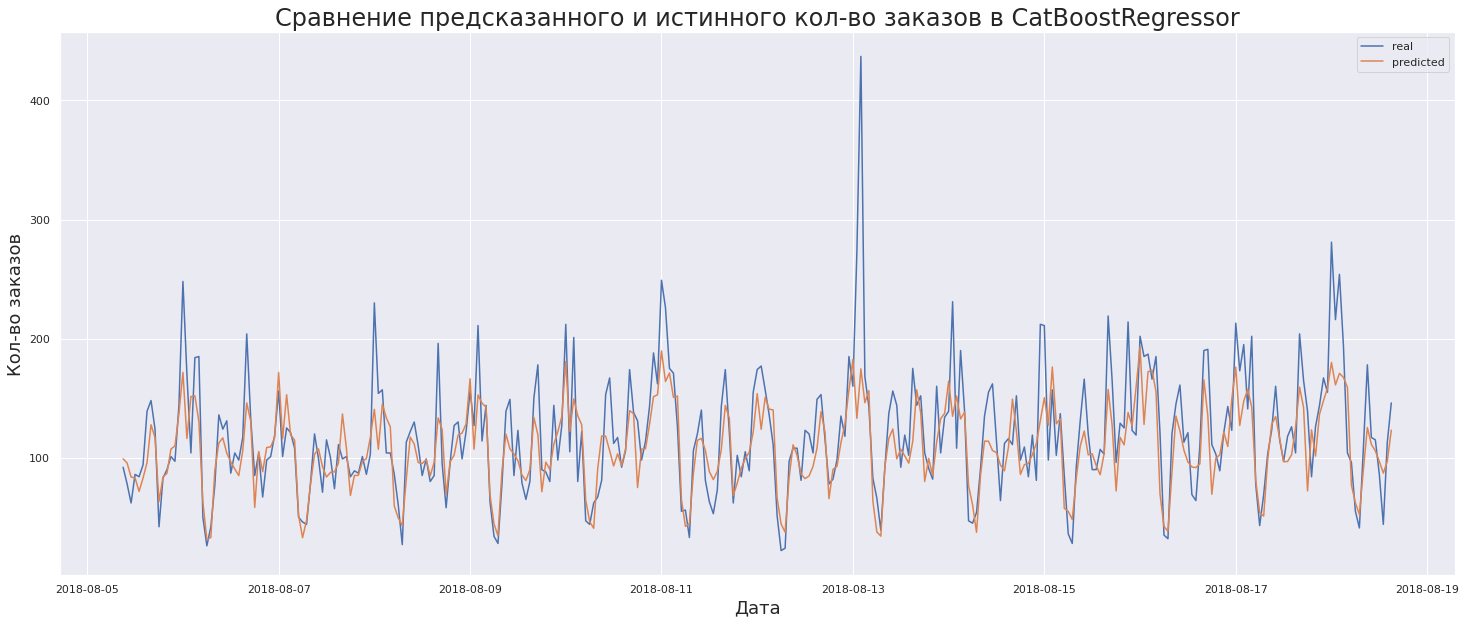

In [52]:
# визуализация
graf(cat_predicted, 'CatBoostRegressor')

In [53]:
# Вносим данные в таблицу
table.add_row(['CatBoostRegressor', rmse_cat])
print(table)

+-------------------+--------------------+
|       model       |        RMSE        |
+-------------------+--------------------+
| Linear Regression |  37.7712236820596  |
|      Prophet      | 31.875369358837524 |
| CatBoostRegressor | 33.10188499140998  |
+-------------------+--------------------+


Мы проанализировали результаты предсказаний на 3 моделях и получили следующие результаты:
- Лучшие предсказания выдала бустинговая модель CatBoostRegressor с RMSE 33.1. Для нее мы подобрали оптимальные гиперпараметры и удалили из данных столбец месяца;
- На втором месте модель Prophet с результатом RSME = 31.81, но при этом отображение на графике выглядит зацикленным, что ставит под сомнение или результат отображение, или предсказание;
- И в конце списка модель Linear Regression с результатом 37.77.



## Тестирование

Так как модель Prophet вызывает сомнения в предсказании, то финальное тестирование будем проводить на CatBoostRegressor.

In [54]:
# Объединим обучающую и валидационные выборки в надежде увеличить немного качество.

features_final = pd.concat([features_train, features_valid])
target_final = pd.concat([target_train, target_valid])

print(features_final.shape)
print(target_final.shape)

(2845, 28)
(2845,)


Лучшее значение RMSE для  финального теста CatBoostRegressor: 40.50798804861327


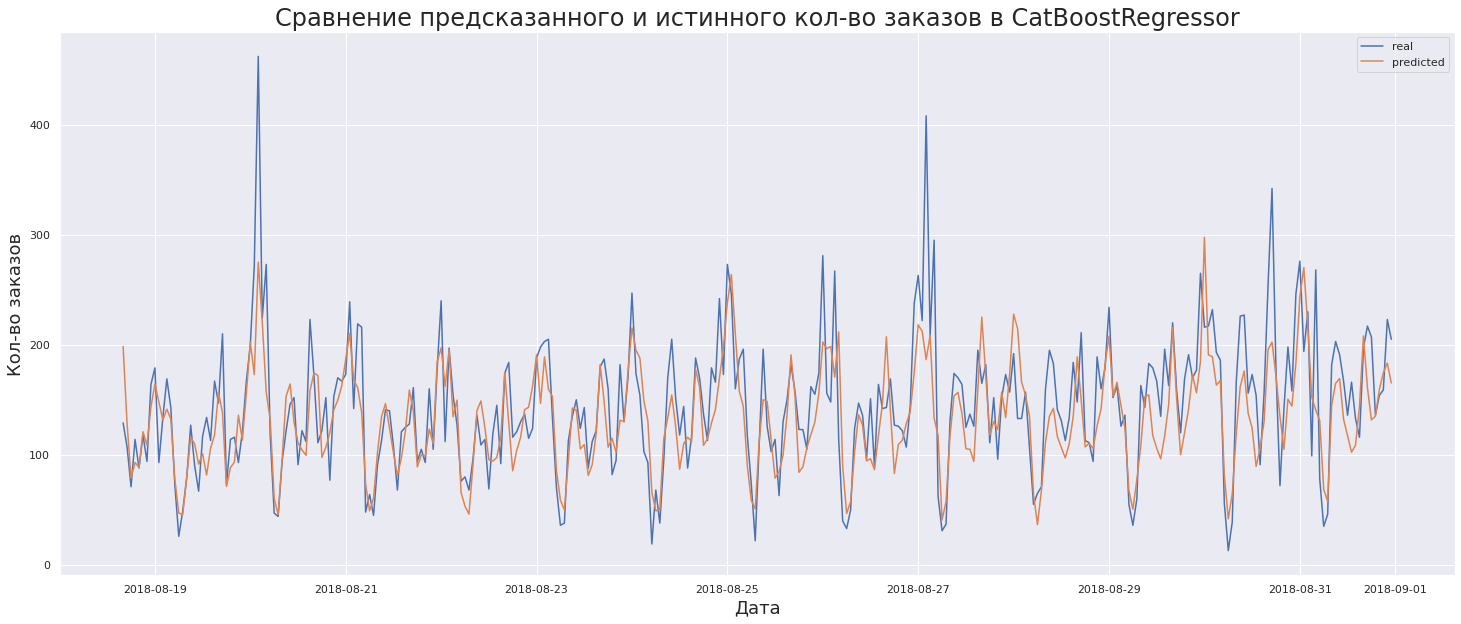

In [55]:
cat = CatBoostRegressor(depth = 5,iterations = 500, learning_rate=0.1, od_type='Iter', od_wait=50, verbose=False) 
cat.fit(features_final, target_final, cat_features=cat_features, plot=False)

final_predicted = cat.predict(features_test)

#  Посчитаем значение метрики на валидационной выборке
rmse_final = rmse(target_test, final_predicted)
print(f'Лучшее значение RMSE для  финального теста CatBoostRegressor: {rmse_final}')

# визуализация
plt.figure(figsize=(25, 10))

sns.lineplot(x=target_test.index, y=target_test, label= 'real')
sns.lineplot(x=target_test.index, y=final_predicted, label='predicted')
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Кол-во заказов', fontsize=18)
plt.legend()
plt.title(f'Сравнение предсказанного и истинного кол-во заказов в CatBoostRegressor', fontsize=24)

plt.show()

In [56]:
# Проверим модель на адекватность

ds = DummyRegressor(strategy='mean')
ds.fit(features_final, target_final)
ds_predicted=ds.predict(features_test)
rmse_ds = rmse(target_test, ds_predicted)
print(f'Лучшее значение RMSE для DummyRegressor: {rmse_ds}')

Лучшее значение RMSE для DummyRegressor: 82.29944320177644


**Вывод:**

Для компания «Чётенькое такси» мы построили модель предсказания количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

С помощью исторические данные о заказах такси в аэропортах мы смогли проанализировать временной ряд и реализовать предсказания с помощью бустинговой модели **CatBoostRegressor** с качеством предсказания по метрики RSME равной на тестовой выборке **40.5**. Таким образом выполнили поставленную задачу: на тестовой выборке значение метрики RMSE должно быть не больше 48. Проверили модель на адекватность. RMSE модели DummyRegressor (82.3) в разы хуже, чем RMSE, полученное на валидационном наборе данных. Это говорит нам о том, что модель машинного обучения лучше предсказывает, чем постоянная модели, предсказывающее среднее значение.

Таких данных добились благодаря тому, что изучили и проанализировали предоставленные данные, обработали информацию, проанализировали временные ряды и выполнили ресемплирование на 1 час. Посмотрели скользящее среднее и выявили тренд и сезонность наших данных, проверили автокорреляцию для определения стационарности временного ряда. Построили несколько моделей для сравнения: Linear Regression, Prophet, CatBoostRegressor. 
